# Data Set Summary Info

This notebook provides summary information and descriptive statistics for our data sets.

## Setup

In [1]:
import sys
import re

In [2]:
from pathlib import Path

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [4]:
import bookgender.datatools as dt

In [5]:
def eprint(*args):
    print(*args, file=sys.stderr)

## Load Data Files

Load book author gender info:

In [6]:
datasets =  sorted(list(dt.datasets.keys()))

In [7]:
book_gender = pd.read_parquet('data/author-gender.parquet')
book_gender['gender'] = book_gender['gender'].astype('category')
book_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10735373 entries, 0 to 10735372
Data columns (total 2 columns):
item      int64
gender    category
dtypes: category(1), int64(1)
memory usage: 92.1 MB


Book gender will be more useful if we index it.

In [8]:
book_gender = book_gender.set_index('item')

Load the Library of Congress book list:

In [9]:
loc_books = pd.read_csv('data/loc-books.csv.gz')
loc_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899517 entries, 0 to 4899516
Data columns (total 1 columns):
item    int64
dtypes: int64(1)
memory usage: 37.4 MB


Load rating data sets:

In [10]:
ratings = {}
for ds in datasets:
    eprint('loading ratings for', ds)
    ratings[ds] = pd.read_parquet(f'data/{ds}/ratings.parquet')

loading ratings for AZ


loading ratings for BX-E
loading ratings for BX-I
loading ratings for GR-E


loading ratings for GR-I


## Basic Data Set Stats

In [11]:
ds_summary = pd.DataFrame.from_dict(dict(
    (n, {'Users': f['user'].nunique(), 'Items': f['item'].nunique(), 'Pairs': len(f)})
    for (n, f) in ratings.items()
), orient='index')
ds_summary['Density'] = ds_summary['Pairs'] / (ds_summary['Users'] * ds_summary['Items'])
ds_summary

,Users,Items,Pairs,Density
AZ,8026324,2269633,22464284,0.000001
BX-E,77805,151961,426929,0.000036
BX-I,105283,279983,1128965,0.000038
GR-E,808782,1081709,86539647,0.000099
GR-I,870011,1097581,188962927,0.000198


In [12]:
def pct_fmt(p):
    return '{:.4f}%'.format(p * 100)
def n_fmt(n):
    return '{:,d}'.format(n)
print(ds_summary.to_latex(formatters={
    'Users': n_fmt,
    'Items': n_fmt,
    'Pairs': n_fmt,
    'Density': pct_fmt
}))

\begin{tabular}{lrrrr}
\toprule
{} &     Users &     Items &       Pairs & Density \\
\midrule
AZ   & 8,026,324 & 2,269,633 &  22,464,284 & 0.0001\% \\
BX-E &    77,805 &   151,961 &     426,929 & 0.0036\% \\
BX-I &   105,283 &   279,983 &   1,128,965 & 0.0038\% \\
GR-E &   808,782 & 1,081,709 &  86,539,647 & 0.0099\% \\
GR-I &   870,011 & 1,097,581 & 188,962,927 & 0.0198\% \\
\bottomrule
\end{tabular}



### Distributions

What is the rating distribution for explicit-feedback data sets?

In [13]:
exp_re = re.compile(r'^\w\w(-E|$)')
[ds for ds in ratings.keys() if exp_re.match(ds)]

['AZ', 'BX-E', 'GR-E']

In [14]:
exp_rate_stats = pd.concat(
    (rates.groupby('rating').item.count().reset_index(name='count').assign(Set=ds)
     for (ds, rates) in ratings.items() if exp_re.match(ds))
, ignore_index=True)
exp_rate_stats.head()

,rating,count,Set
0,1.0,1115189,AZ
1,1.5,231,AZ
2,2.0,976957,AZ
3,2.5,410,AZ
4,3.0,1918358,AZ


C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


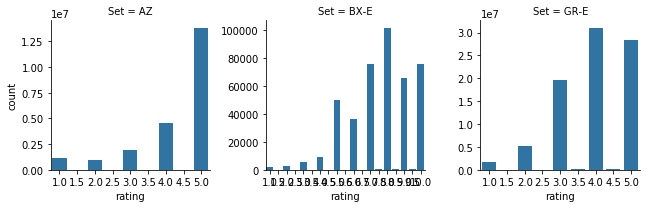

In [15]:
grid = sns.FacetGrid(col='Set', data=exp_rate_stats, sharex=False, sharey=False)
grid.map(sns.barplot, 'rating', 'count')

In [16]:
user_means = pd.concat(
    (rates.groupby('user').rating.mean().reset_index(name='AvgRating').assign(Set=ds)
     for (ds, rates) in ratings.items() if exp_re.match(ds))
, ignore_index=True)
user_means.head()

,user,AvgRating,Set
0,1,5.000000,AZ
1,2,5.000000,AZ
2,3,5.000000,AZ
3,4,4.666667,AZ
4,5,4.000000,AZ


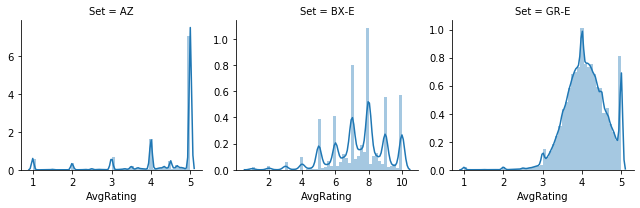

In [17]:
grid = sns.FacetGrid(col='Set', data=user_means, sharey=False, sharex=False)
grid.map(sns.distplot, 'AvgRating')

In [18]:
item_means = pd.concat(
    (rates.groupby('item').rating.mean().reset_index(name='AvgRating').assign(Set=ds)
     for (ds, rates) in ratings.items() if exp_re.match(ds))
, ignore_index=True)
item_means.head()

,item,AvgRating,Set
0,101005678,5.000000,AZ
1,101005735,4.250000,AZ
2,101005801,4.750000,AZ
3,101005833,3.692308,AZ
4,101005899,4.000000,AZ


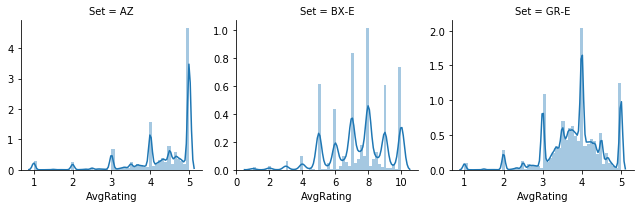

In [19]:
grid = sns.FacetGrid(col='Set', data=item_means, sharey=False, sharex=False)
grid.map(sns.distplot, 'AvgRating')

## Count and Integrate

Now that we have the data loaded, we need to do a few things:

1. Connect with gender info
2. Count books (or ratings) by gender. All kinds of unlinked gender are mapped to `unlinked`.
3. Integrate into a single set of lists

To start, we'll define a couple of helper for counting books or ratings:

In [20]:
def gender_info(books, full=False):
    # get gender info
    books = books.join(book_gender, on='item', how='left')
    # normalize things
    if full:
        books['gender'].cat.add_categories(['no-book'], inplace=True)
        books['gender'].fillna('no-book', inplace=True)
        books['gender'].cat.reorder_categories(['no-book', 'no-loc-author', 'no-viaf-author',
                                                'unknown', 'ambiguous', 'female', 'male'], inplace=True)
    else:
        books['gender'].cat.add_categories(['unlinked'], inplace=True)
        books['gender'].fillna('unlinked', inplace=True)
        books.loc[books['gender'] == 'no-loc-author', 'gender'] = 'unlinked'
        books.loc[books['gender'] == 'no-viaf-author', 'gender'] = 'unlinked'
        books['gender'].cat.remove_unused_categories(inplace=True)
        books['gender'].cat.reorder_categories(['female', 'male', 'ambiguous', 'unknown', 'unlinked'], inplace=True)
    return books

In [21]:
def summarize_by_gender(book_frame, full=False):
    # we only need the item column
    books = gender_info(book_frame[['item']], full)

    # join and count
    counts = books.groupby('gender').agg(['count', 'nunique']).droplevel(0, axis=1)
    counts = counts.rename(columns={'count': 'Ratings', 'nunique': 'Books'})
    return counts

Let's see the function in action:

In [22]:
summarize_by_gender(ratings['BX-E'])

,Ratings,Books
gender,,
female,139920,37724
male,185344,55461
ambiguous,27700,3567
unknown,27109,17609
unlinked,46856,37600


Now build up a full frame of everything:

In [23]:
eprint('summarizing LOC')
summaries = {'LOC': summarize_by_gender(loc_books)}
for ds, f in ratings.items():
    eprint('summarizing', ds)
    summaries[ds] = summarize_by_gender(f)
gender_stats = pd.concat(summaries, names=['DataSet'])
gender_stats.info()

summarizing LOC


summarizing AZ


summarizing BX-E


summarizing BX-I


summarizing GR-E


summarizing GR-I


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30 entries, (LOC, female) to (GR-I, unlinked)
Data columns (total 2 columns):
Ratings    30 non-null int64
Books      30 non-null int64
dtypes: int64(2)
memory usage: 904.0+ bytes


In [24]:
eprint('summarizing LOC')
fsums = {'LOC': summarize_by_gender(loc_books, True)}
for ds, f in ratings.items():
    eprint('summarizing', ds)
    fsums[ds] = summarize_by_gender(f, True)
full_stats = pd.concat(fsums, names=['DataSet'])
full_stats.info()

summarizing LOC


summarizing AZ


summarizing BX-E


summarizing BX-I


summarizing GR-E


summarizing GR-I


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 42 entries, (LOC, ambiguous) to (GR-I, no-book)
Data columns (total 2 columns):
Ratings    42 non-null int64
Books      42 non-null int64
dtypes: int64(2)
memory usage: 1.3+ KB


In [25]:
book_counts = full_stats['Books'].unstack()
book_counts = book_counts[['no-book', 'no-loc-author', 'no-viaf-author', 'unknown', 'ambiguous', 'male', 'female']]
book_counts

gender,no-book,no-loc-author,no-viaf-author,unknown,ambiguous,male,female
DataSet,,,,,,,
LOC,0,762990,294698,1210534,45127,1998623,587545
AZ,1048605,161399,151594,238602,14937,454136,200360
BX-E,23270,6597,7733,17609,3567,55461,37724
BX-I,46665,13133,15844,36432,5943,96030,65936
GR-E,0,575984,29315,86072,9093,237272,143973
GR-I,0,585136,30074,87724,9183,240167,145297


In [26]:
book_counts[['no-book', 'no-loc-author', 'no-viaf-author']].sum(axis=1)

DataSet
LOC     1057688
AZ      1361598
BX-E      37600
BX-I      75642
GR-E     605299
GR-I     615210
dtype: int64

# book_counts.divide(book_counts.sum(axis=1), axis=0) * 100

In [27]:
print((book_counts.divide(book_counts.sum(axis=1), axis=0) * 100).to_latex(float_format='%.1f%%'))

\begin{tabular}{lrrrrrrr}
\toprule
gender &  no-book &  no-loc-author &  no-viaf-author &  unknown &  ambiguous &  male &  female \\
DataSet &          &                &                 &          &            &       &         \\
\midrule
LOC     &     0.0\% &          15.6\% &            6.0\% &    24.7\% &       0.9\% & 40.8\% &   12.0\% \\
AZ      &    46.2\% &           7.1\% &            6.7\% &    10.5\% &       0.7\% & 20.0\% &    8.8\% \\
BX-E    &    15.3\% &           4.3\% &            5.1\% &    11.6\% &       2.3\% & 36.5\% &   24.8\% \\
BX-I    &    16.7\% &           4.7\% &            5.7\% &    13.0\% &       2.1\% & 34.3\% &   23.6\% \\
GR-E    &     0.0\% &          53.2\% &            2.7\% &     8.0\% &       0.8\% & 21.9\% &   13.3\% \\
GR-I    &     0.0\% &          53.3\% &            2.7\% &     8.0\% &       0.8\% & 21.9\% &   13.2\% \\
\bottomrule
\end{tabular}



To facilitate plotting, we need to do a few more transformations:

1. Shift into a tall format with a `Scope`
2. Convert counts to percents
3. Drop the LOC Ratings, because it is meaningless

In [28]:
gs_tall = pd.DataFrame({'Count': gender_stats.stack()})
gs_tall.index.rename(['DataSet', 'Gender', 'Scope'], inplace=True)
gs_tall = gs_tall.reorder_levels(['DataSet', 'Scope', 'Gender']).sort_index()
gs_tall['Fraction'] = gs_tall['Count'] / gs_tall.groupby(level=['DataSet', 'Scope'])['Count'].sum()
gs_tall.drop(('LOC', 'Ratings'), inplace=True)
gs_tall.reset_index(inplace=True)
gs_tall

,DataSet,Scope,Gender,Count,Fraction
0,AZ,Books,female,200360,0.088279
1,AZ,Books,male,454136,0.200092
2,AZ,Books,ambiguous,14937,0.006581
3,AZ,Books,unknown,238602,0.105128
4,AZ,Books,unlinked,1361598,0.599920
5,AZ,Ratings,female,3932954,0.175076
6,AZ,Ratings,male,6174036,0.274838
7,AZ,Ratings,ambiguous,449440,0.020007
8,AZ,Ratings,unknown,1977869,0.088045
9,AZ,Ratings,unlinked,9929985,0.442034


In [29]:
gs_tall['DataSet'] = gs_tall['DataSet'].astype('category').cat.reorder_categories(['LOC', 'AZ', 'BX-I', 'BX-E', 'GR-I', 'GR-E'])

Finally, we can plot it:

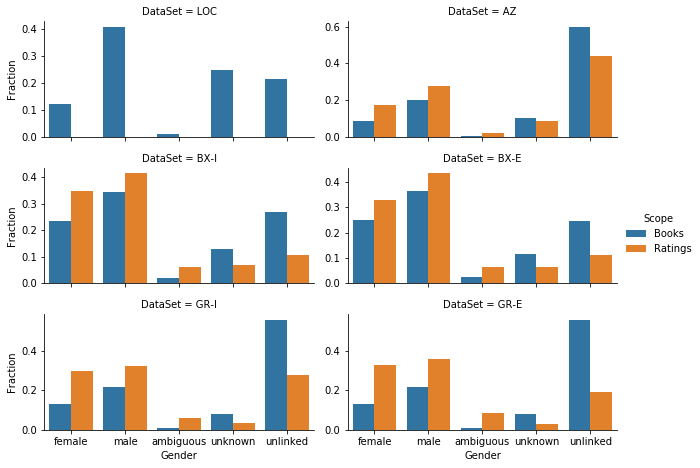

In [30]:
sns.catplot(x='Gender', y='Fraction', col='DataSet', col_wrap=2, hue='Scope', data=gs_tall,
            kind='bar', sharey=False, height=2.2, aspect=2)
plt.savefig('figures/link-stats.pdf')

Known-gender books:

In [31]:
k_bc = book_counts[['male', 'female']]
k_bf = k_bc.divide(k_bc.sum(axis=1), axis=0)
k_bf = k_bf.loc[['LOC', 'AZ', 'BX-I', 'GR-I']]
k_bf

gender,male,female
DataSet,,
LOC,0.772813,0.227187
AZ,0.693871,0.306129
BX-I,0.592902,0.407098
GR-I,0.623059,0.376941


In [32]:
print(k_bf.to_latex())

\begin{tabular}{lrr}
\toprule
gender &      male &    female \\
DataSet &           &           \\
\midrule
LOC     &  0.772813 &  0.227187 \\
AZ      &  0.693871 &  0.306129 \\
BX-I    &  0.592902 &  0.407098 \\
GR-I    &  0.623059 &  0.376941 \\
\bottomrule
\end{tabular}



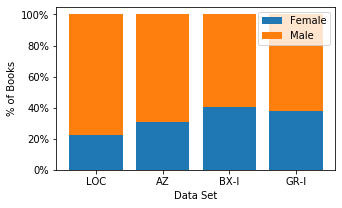

In [33]:
plt.figure(figsize=(5, 3))
ax = plt.subplot()
ax.bar(k_bf.index, k_bf.female, label='Female')
ax.bar(k_bf.index, k_bf.male, bottom=k_bf.female, label='Male')
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])
plt.legend()
ax.set_ylabel('% of Books')
ax.set_xlabel('Data Set')
plt.savefig('figures/frac-known-books.pdf')

And do that again for ratings.

In [34]:
rate_counts = full_stats['Ratings'].unstack()
k_rc = rate_counts[['male', 'female']]
k_rf = k_rc.divide(k_rc.sum(axis=1), axis=0)
k_rf = k_rf.loc[['AZ', 'BX-I', 'BX-E', 'GR-I', 'BX-I']]
k_rf

gender,male,female
DataSet,,
AZ,0.610868,0.389132
BX-I,0.542827,0.457173
BX-E,0.569826,0.430174
GR-I,0.517739,0.482261
BX-I,0.542827,0.457173


In [35]:
all_cts = full_stats.reorder_levels([1,0]).loc[['male', 'female']].reorder_levels([1,0]).unstack()
all_cts.sort_index(axis=1, inplace=True)
print(all_cts.divide(all_cts.sum(axis=1, level=0), axis=0, level=0).to_latex(float_format=lambda f: '{:.1f}%'.format(f*100)))

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{Books} & \multicolumn{2}{l}{Ratings} \\
gender & female &  male &  female &  male \\
DataSet &        &       &         &       \\
\midrule
LOC     &  22.7\% & 77.3\% &   22.7\% & 77.3\% \\
AZ      &  30.6\% & 69.4\% &   38.9\% & 61.1\% \\
BX-E    &  40.5\% & 59.5\% &   43.0\% & 57.0\% \\
BX-I    &  40.7\% & 59.3\% &   45.7\% & 54.3\% \\
GR-E    &  37.8\% & 62.2\% &   47.6\% & 52.4\% \\
GR-I    &  37.7\% & 62.3\% &   48.2\% & 51.8\% \\
\bottomrule
\end{tabular}



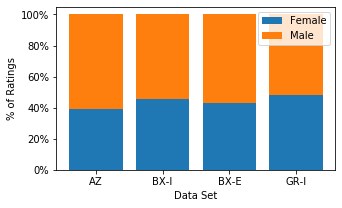

In [36]:
plt.figure(figsize=(5, 3))
ax = plt.subplot()
ax.bar(k_rf.index, k_rf.female, label='Female')
ax.bar(k_rf.index, k_rf.male, bottom=k_rf.female, label='Male')
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])
plt.legend()
ax.set_ylabel('% of Ratings')
ax.set_xlabel('Data Set')
plt.savefig('figures/frac-known-rates.pdf')

## Evaluate by Popularity

In [37]:
bxi_istats = ratings['BX-I'].groupby('item').user.count().reset_index(name='nratings')
bxi_istats = gender_info(bxi_istats)
bxi_istats.head()

,item,nratings,gender
0,101005772,1,male
1,101005947,1,unknown
2,101006165,1,ambiguous
3,101006411,13,male
4,101006593,1,male


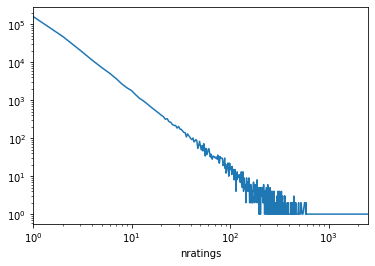

In [38]:
bxi_ipops = bxi_istats.groupby('nratings').item.count().plot(loglog=True)

In [39]:
bxi_istats['PopRank'] = bxi_istats.nratings.rank() / len(bxi_istats)
bxi_istats['PopQ'] = bxi_istats['PopRank'].round(3)
bxi_istats['LogPop'] = np.log10(bxi_istats.nratings)
bxi_istats['LogPR'] = bxi_istats['LogPop'].round(1)

In [40]:
bxi_pop_gender = bxi_istats.groupby(['LogPR', 'gender']).item.count().unstack(fill_value=0)
bxi_pop_gender = bxi_pop_gender.divide(bxi_pop_gender.sum(axis=1), axis='rows')
bxi_pop_gender.tail()

gender,female,male,ambiguous,unknown,unlinked
LogPR,,,,,
3.0,0.142857,0.714286,0.142857,0.0,0.0
3.1,0.500000,0.000000,0.500000,0.0,0.0
3.2,0.500000,0.000000,0.500000,0.0,0.0
3.3,0.000000,0.000000,1.000000,0.0,0.0
3.4,0.000000,1.000000,0.000000,0.0,0.0


In [41]:
bxi_pg = bxi_pop_gender.stack().reset_index(name='Fraction')
bxi_pg['gender'] = bxi_pg['gender'].astype('object')
bxi_pg.head()

,LogPR,gender,Fraction
0,0.0,female,0.177708
1,0.0,male,0.320315
2,0.0,ambiguous,0.015932
3,0.0,unknown,0.141650
4,0.0,unlinked,0.344395


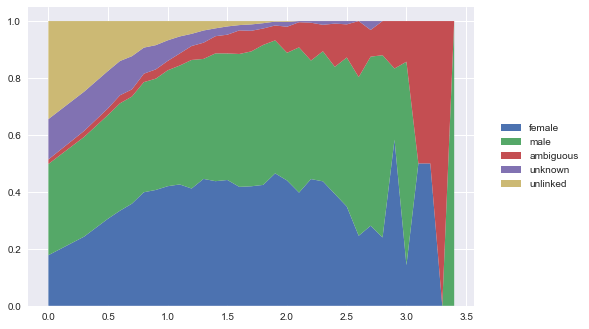

In [42]:
plt.style.use('seaborn')
plt.stackplot(bxi_pop_gender.index,
              [bxi_pop_gender[c] for c in bxi_pop_gender.columns],
              labels=bxi_pop_gender.columns)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")